In [0]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from scipy import stats

To illustrate our intuition of classification we can generate some random data, create a model using Linear Regression and plot the result. For simplicity we will avoid real datasets for the time being. The scikit-learn library contains a datasets package that allows us to generate datasets with any properties that we wish to examine.

First, we use the datasets package to generate 200 samples with two classes. Then we fit a Linear regression model with the data. Next, we use the `mlxtend` library to automatically plot the data points and the classification regions.

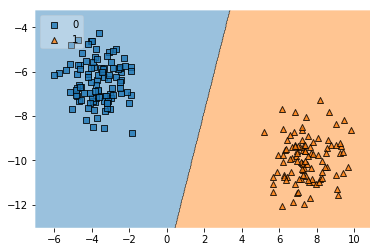

In [0]:
X, y = make_blobs(n_samples=200, centers=2, n_features=2, cluster_std=1.0)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X, y)

plot_decision_regions(X, y, clf=lr, legend=2)
plt.show()


In the plot, we can clearly see two regions. Any datapoint on the right of the boundary line will be classified into one class and any datapoint on the left will be classified into the other class. We can see that this ideal dataset is properly classified into one class or the other. We do not always, if ever, encounter such neat data in real life. We can make the data a little less neat by increasing the standard deviation of the clusters.

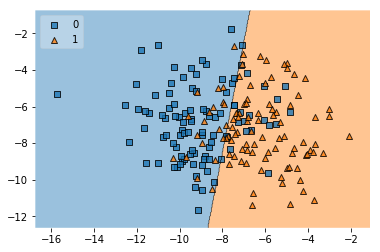

In [0]:
X, y = make_blobs(n_samples=200, centers=2, n_features=2, cluster_std=2.0)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X, y)

plot_decision_regions(X, y, clf=lr, legend=2)
plt.show()

This time there are some datapoints that end up on the wrong side of the boundary line. There is no way to draw a single straight line to cleanly separate these two groups of data. ***Note: you may have to run the code cell multiple times to see the effect as the points are generated at random***.

This example is illustrated using just 2 features making it easy to plot on a two-dimensional screen and drawing a simple line to show the boundary. With more features the same thing happens but in higher dimensions. For instance with 3 features we will plot the points in three-dimensional space and separate the categories with a plane (think like a flat sheet of paper). In higher dimensions it becomes even harder to visualize but mathematically it is the same process.

With that we can state the following definitions:

 - Classification algorithm: learn to predict categories from given features.
 - Decision boundary: the surface separating different predicted classes.
 - Linear classifier: the decision boundary is linear (a straight line).
 - Linearly separable: a dataset can be separated by a linear classifier. 
 
This last one implies that not all datasets are suitable for linear classifications. Sometimes data may come in other forms that require different algorithms for classification.

This lesson will take a deep dive into how a linear classifier works.

Consider the following subset of 50 samples from the Breast Cancer Wisconsin dataset. 

In [0]:
# load the dataset
breast_cancer = load_breast_cancer()

# select 50 samples and 2 features (for simplicity)
data_df = pd.DataFrame(breast_cancer.data[25:75], columns=breast_cancer.feature_names)
data_df = data_df[['mean radius', 'mean compactness']]
target_df = pd.DataFrame(breast_cancer.target[25:75])
target_df.columns = ['benign']

# get the min and max on the x axis for plotting lines later
minX = data_df['mean radius'].min()
maxX = data_df['mean radius'].max()

print(data_df.head())
print(target_df.head())

   mean radius  mean compactness
0        17.14            0.2276
1        14.58            0.1868
2        18.61            0.1066
3        15.30            0.1697
4        17.57            0.1157
   benign
0       0
1       0
2       0
3       0
4       0


We can plot these two features.

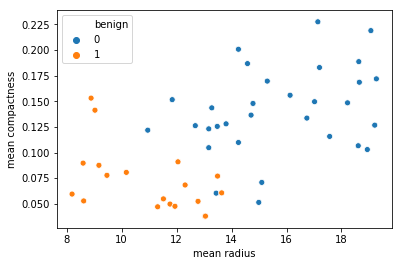

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x = 'mean radius', y = 'mean compactness', data = data_df, hue=target_df['benign'])
plt.show()



```
# This is formatted as code
```

At a glance, we can see that as the radius increases the chances of being malignant increases. The process of classification is finding the line that will separate these two classes of data. Let's say we were to "guess" a line. First, we could write a function that will plot a straight line given some parameters.

In [0]:
def drawLine(plt, m, c, min, max):
  x = np.linspace(min, max)
  y = m * x + c
  plt.plot(x, y, 'g-')

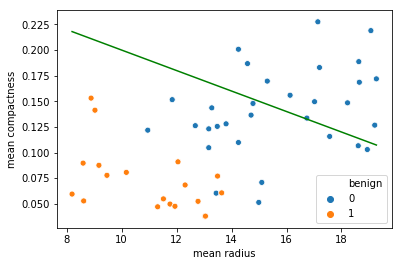

In [0]:
sns.scatterplot(x = 'mean radius', y = 'mean compactness', data = data_df, hue=target_df['benign'])
# draw a line at some arbitrary place
drawLine(plt, -0.01, 0.3, minX, maxX)
plt.show()

Our guess does not do such a good job at separating the space. So let's adjust the line slightly and see if that makes a difference.

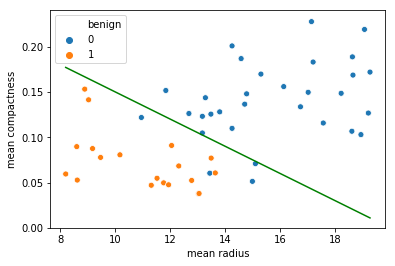

In [0]:
sns.scatterplot(x = 'mean radius', y = 'mean compactness', data = data_df, hue=target_df['benign'])
drawLine(plt, -0.015, 0.3, minX, maxX)
plt.show()

Just by eyeballing the plot we can see that this is a little better. And we determine that it is better by looking at how many blue dots are on the wrong side of the line. In the first plot, there were 17 blue dots and 0 yellow dots on the wrong side of the line. After we adjusted the line there were 4 blue dots and 0 yellow dots on the wrong side of the line. Since there are fewer errors with the second line placement we may assume that it is a better boundary. We can keep adjusting slightly until we find a line that generates the least number of errors.

Let's try one more adjustment.

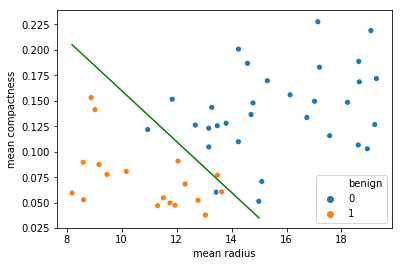

In [0]:
sns.scatterplot(x = 'mean radius', y = 'mean compactness', data = data_df, hue=target_df['benign'])
drawLine(plt, -0.025, 0.41, minX, 15)
plt.show()

This time there are 2 blue dot errors and 1 yellow dot error for a total of 3 errors. When we find the line that *minimizes* the error we can stop. 

## Equation of a line
Recall that the equation of a line is:

$$ y = mx + c$$

Where `m` is the slope or gradient and `c` is the y intercept. 

You may have noticed that in the examples above we have been manipulating the values for `m` and `c` to adjust the boundary line. These values are the **parameters** or **coefficients** that we search for in order to find a boundary that minimizes the error.

So let's summarize what we know so far:

1. This is a supervised learning problem - that means we have labeled data to work with.
2. We are trying to find a linear decision boundary between 2 (or more) classes of data points.
3. There is some error function - a way to determine the accuracy of our decision boundary.
4. The whole process is about minimizing this error function.

## Hypothesis Function
Let us take a look at why this algorithm is called *Logistic Regression*. 

Say we have a dataset of two features. Given these two features, we want to determine some relationship or pattern that maps these features onto a target or label. For example, given a mean radius and mean compactness of a tumor we want to map those values to either a  1 (benign) or 0 (malignant). That is, we want to develop a function of the form:

$$  y = f(x) $$

that predicts `y` given the input features `x`. However, we do not know the function `f(x)` just as yet. So we refer to it as the **hypothesis** function and denote it with `h(x)`. 

The hypothesis function takes the form:

$$ h_{\theta}(x) = \theta_0 + \theta_1x_1 + \theta_2x_2$$

The values $\theta_0, \theta_1$ and $\theta_2$ are parameters (sometimes called **weights**) that we tune as we fit the function to the data. The values $x_1$ and $x_2$ are the features. 

Think of $\theta_0$ as some base value that determines if a tumor is malignant or not, sometimes called a **bias**.  $\theta_1$ is the amount of contribution that the first feature, mean radius in this case, contributes to the decision and $\theta_2$ is the amount of contribution of the second feature to the decision. Hopefully it can be seen that this can be extended to any number of features.

$$ h_{\theta}(x) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \ldots + \theta_nx_n$$

For convenience, we define a vector

$$\theta = \begin{bmatrix}\theta_0 \\ \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n\end{bmatrix}$$

and a vector

$$ x = \begin{bmatrix}x_0 \\ x_{1} \\ x_{2} \\ \vdots \\ x_{n} \end{bmatrix} $$

So the hypothesis function may be concisely represented as:

$$ h_\theta(x) = \begin{bmatrix}\theta_0  & \theta_1 & \theta_2  & \ldots & \theta_n \end{bmatrix}\begin{bmatrix}x_0 \\ x_{1} \\ x_{2} \\ \vdots \\ x_{n} \end{bmatrix} = \theta^Tx$$

The symbol $\theta^T$ simply means "the transpose of $\theta$". That is, a column vector transposed becomes a row vector and vice versa. Basic matrix multiplication would show that this concise form of the expression is the same as the original form.

You may have noticed that given `n` features we create a vector `x` of `n + 1` elements. For convenience we assign the value 1 to $x_0$ for all rows of data in the dataset. This makes it easier to perform matrix multiplication between $\theta$ and $x$.




But, recall that we want y to take on the values 0 or 1 and no other value.  The hypothesis function as given will generate numbers outside of this range. This is where the *Logistic* part of the Logistic Regression comes in. We take the hypothesis function and pass it through a **Logistic Function** (also called a **Sigmoid Function**).

### Logistic Function
The Logistic fuction takes the form:

$$ g(z) = \frac{1}{1 + e^{-z}}$$

If we plot this function it looks like this:

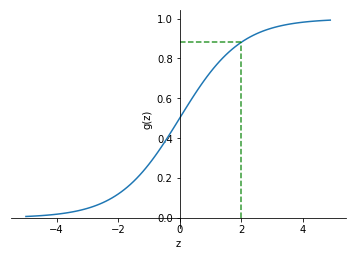

In [0]:
z = np.arange(-5, 5, 0.1)
g = 1 / (1 + np.exp(-z))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.plot(z, g)
plt.plot([2, 2], [0, (1/(1 + np.exp(-2)))], 'g--', alpha = 0.8)
plt.plot([0, 2], [(1/(1 + np.exp(-2))), (1/(1 + np.exp(-2)))], 'g--', alpha = 0.8)
plt.xlabel('z')
plt.ylabel('g(z)')
plt.show()

This function is used to map any real number to the  (0, 1) interval. That is, given any value $z$ plot it on the horizontal axis, take a perpendicular up to the line then read the corresponding value of the vertical axis. For example, 2 on the horizontal axis maps to about 0.88 on the vertical axis.

So given the function $g(z)$ as defined above we can define the hypothesis function as 

$$ h_\theta(x) = g(\theta^Tx) $$

where we set $$z = \theta^Tx $$

Let us write up an implementation in python.

In [0]:
# z is a vector of real numbers
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def predict(features, weights):
  z = np.dot(features, weights)
  return sigmoid(z)



Since we are now guaranteed to get a value in the interval (0, 1) we could further define:

$$ y = \begin{cases}1  & \text{ if } h_\theta(x) \ge 0.5 \\ 0 & \text{ if } h_\theta(x) \lt 0.5\end{cases} $$

## A Worked Example
Let's walk through a simple worked example. Suppose we had the following data with two features.

Sample # |$x_1$ | $x_2$ | target
--- | --- | --- | ---
1 | 0.4 | 1.3 | 1
2 | 0.1 | 0.002 | 0

and after running our algorithm it generated the model defined by:

$$ \theta = \begin{bmatrix} 0.1 \\ -1.2 \\ 0.3 \end{bmatrix} $$

**For sample 1:**

$$ x^1 = \begin{bmatrix} 1 \\ 0.4 \\ 1.3 \end{bmatrix}$$

so performing $ z= \theta^Tx$ gives:

$$ \begin{align*}z & = \begin{bmatrix} 0.1 & -1.2 & 0.3 \end{bmatrix}\begin{bmatrix} 1 \\ 0.4 \\ 1.3 \end{bmatrix} \\ &= 0.1 \times 1 + -1.2 \times 0.4 + 0.3 \times 1.3 \\ &= 0.010\end{align*} $$

Then plotting this on the sigmoid function:

$$ \begin{align*}g(0.010) & = \frac{1}{1 + e^{-0.010}} \\ &= 0.502 \end{align*}$$

Therefore 

$$ y = 1 \text{ because }  h_\theta(x^1) \ge 0.5 $$ 

**For sample 2:**

$$ x^2 = \begin{bmatrix} 1 \\ 0.1 \\ 0.002 \end{bmatrix}$$

so performing $z = \theta^Tx$ gives:

$$ \begin{align*}z & = \begin{bmatrix} 0.1 & -1.2 & 0.3 \end{bmatrix}\begin{bmatrix} 1 \\ 0.1 \\ 0.002 \end{bmatrix} \\ &= 0.1 \times 1 + -1.2 \times 0.1 + 1.3 \times 0.002 \\ &= -0.019\end{align*} $$

Then plotting this on the sigmoid function:

$$ \begin{align*}g(0.14) & = \frac{1}{1 + e^{--0.019}} \\ &= 0.495 \end{align*}$$

Therefore 

$$ y = 0 \text{ because } h_\theta(x^2) \lt 0.5 $$


For the first sample the model predicted 1 and for the second sample the model predicted 0.





In [0]:
x1 = [1, 0.4, 1.3]
theta = [0.1, -1.2, 0.3]
sample1 = predict(x1, theta)

print('For sample 1: ', sample1)

x2 = [1, 0.1, 0.002]
sample2 = predict(x2, theta)

print('For sample 2: ', sample2)

For sample 1:  0.502499979166875
For sample 2:  0.49515015210644203


## Cost Function
Now that we see how we can use the hypothesis function to make some predictions, the next step is to measure the accuracy of the function. If the accuracy is too low we then adjust some parameters and measure the accuracy of the updated function. Repeat until we are satisfied with the accuracy or we simply cannot get better accuracy.

In this section, we will examine the function that we use to measure the accuracy of the hypothesis function. This is known as the **cost function** or **error function**. 

For a given data sample we can use the set of features $x$ to calculate the prediction given by our hypothesis function as we did above and compare it to the actual label for that sample $y$. If the prediction is different from the actual value of $y$ then we have an error. We then need to perform this for all samples in our training set and sum the errors for a total error.

The objective of the algorithm is to minimize the error. The cost function used in Logistic regression is defined by:

$$ cost(h_\theta(x), y) = \begin{cases} -log(h_\theta(x)) & \text{if} & y = 1 \\ -log(1 - h_\theta(x)) & \text{if} & y = 0\end{cases}$$

These two functions are plotted below.

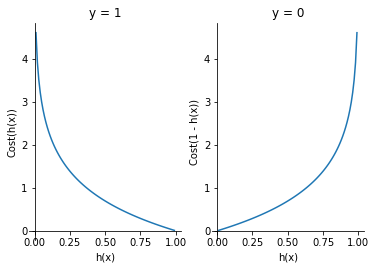

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2)
z = np.arange(0.01, 1, 0.01)
g = -np.log(z)
ax1.spines['left'].set_position(('data', 0.0))
ax1.spines['bottom'].set_position(('data', 0.0))
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.plot(z, g)
ax1.set(xlabel='h(x)', ylabel='Cost(h(x))')
ax1.set_title('y = 1')

g = -np.log(1 - z)
ax2.spines['left'].set_position(('data', 0.0))
ax2.spines['bottom'].set_position(('data', 0.0))
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.plot(z, g)
ax2.set(xlabel='h(x)', ylabel='Cost(1 - h(x))')
ax2.set_title('y = 0')

plt.show()

The left-hand graph shows the function $-log(h_\theta(x))$. If y = 1 and the hypothesis function returns 1 the penalty is 0, but if the hypothesis function returns 0 the penalty is very large. Similarly, the right-hand side illustrates that if $y = 0$ then a prediction of 1 results in a large penalty but a prediction of 0 has no penalty.

We can restate that cost function in a single line to make it easier to code.

$$ cost(h_\theta(x), y) = -ylog(h_\theta(x)) - (1 - y)log(1 - h_\theta(x))$$

In the cell below this is illustrated in code.

In [0]:

def cost(pred, y):
  return -y * np.log(pred) - (1 - y) * np.log(1 - pred)

# prediction is close to zero, y = 0 (small error)
y = 0
pred = 0.00001
print("y = 0, pred close to zero: ", cost(pred, y))

# prediction close to 1, y = 0 (large error)
pred = 0.99999
print("y = 0, pred close to one: ", cost(pred, y))

y = 1
pred = 0.00001
# prediction close to zero, y = 1 (large error)
print("y = 1, pred close to zero: ", cost(pred, y))

# prediction close to 1, y = 1 (small error)
pred = 0.99999
print("y = 1, pred close to one: ", cost(pred, y))



y = 0, pred close to zero:  1.0000050000287824e-05
y = 0, pred close to one:  11.51292546497478
y = 1, pred close to zero:  11.512925464970229
y = 1, pred close to one:  1.0000050000287824e-05


Now that we have an effective cost function we could use it to calculate optimum parameters for the model. There are several algorithms that may be used here. The most straightforward one to understand is called **Gradient Descent**. 



## Gradient Descent Algorithm

Gradient Descent is a fairly simple iterative algorithm. It involves repeatedly updating the parameters to the hypothesis function and measuring the error until the error is as small as possible.

To conceptualize this algorithm imagine that you were standing on the side of a mountain and wished to walk to the lowest point in the landscape. For instance, in the image below you are the blue dot close to the highest point in the landscape.

![Gradient Descent Image 1](assets/gradient_descent_1.png)


You look around in all directions and consider what happens if you take a single step in each direction. In some directions you will go higher up the mountain, sometimes you go lower down the mountain and sometimes you stay at roughly the same height. So you choose the step that takes you furthest downhill. Then you repeat that process taking another step that takes you further downhill. Eventually, you get to a point where no step takes you further downhill. At that point, you are at the minimum point on the surface.

![Gradient Descent Image 2](assets/gradient_descent_2.png)

In this scenario, there are a number of things that we could vary a bit to change the outcome. First, the size of step we take may matter. If it is too large then we risk overstepping the lowest point. If we make it too small then we have a better chance of reaching the lowest point but with every small step we have the recalculate the gradient and that can be costly. What we try to do is start off taking large steps but gradually reduce the size of the step. The size of the step is called the learning rate.

Second, this visualization illustrates the cost function. The lowest point is the lowest cost. This is easier to see in two or three dimensions but in most real-world scenarios you will be working with high dimensional data.

Below is a 2-dimensional plot illustrating the same concept. The blue dot represents the current position, slope represents the error. The global minimum is the point where the slope is 0. Gradient descent moves us downwards in this example towards the smaller slope. 


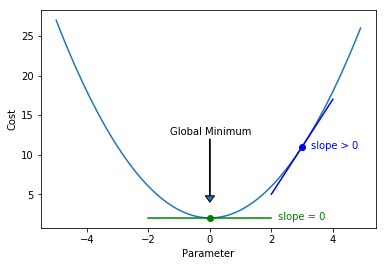

In [0]:
z = np.arange(-5, 5, 0.1)
g = z**2 + 2

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(z, g)
plt.plot([0], [2], 'og')
plt.plot([-2, 2], [2, 2], '-g')
plt.arrow(0, 12, 0, -8, length_includes_head=True, head_width=0.3, head_length=0.8)
plt.text(-1.3, 12.5, 'Global Minimum')

plt.text(2.2, 1.8, 'slope = 0', color='g')
plt.plot([3], [11], 'ob')
plt.plot([2, 4], [5, 17], '-b')
plt.text(3.3, 10.8, 'slope > 0', color='b' )
plt.xlabel('Parameter')
plt.ylabel('Cost')
plt.show()


Below is a full implementation of the algorithm as described so far. Some of the functions written above have been repeated for convenience. Note that this is a rather naive implementation designed to simply illustrate the process- so it should not be used in practice. The Scikit-learn implementation is highly optimized for use in a wide variety of scenarios.

In [0]:

def cost(pred, y):
  return (-y * np.log(pred)) - ((1 - y) * np.log(1 - pred))

def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def predict(features, weights):
  z = np.dot(features, weights)
  return sigmoid(z)

# This function is doing the main work of updating the weights in each iteration
def update_theta(features, weights, labels, learning_rate):
  M = len(features)
  predictions = predict(features, weights)
  gradient = np.dot(features.T, predictions - labels)
  gradient /= M   # calculate gradient average
  gradient *= learning_rate # multiply by learning rate
  weights -= gradient # subtract from weights
  return weights


def train(features, labels, weights, learning_rate, iters):
    cost_history = []

    for i in range(iters):
        weights = update_theta(features, weights, labels, learning_rate)

        #Calculate error for auditing purposes
        pred = predict(features, weights)

        iter_cost = cost(pred, labels)
        cost_history.append(iter_cost.sum())


    return weights, cost_history
  



To try our own logistic regression classifier let us load up the breast cancer dataset again. 

In [0]:
# load the dataset
breast_cancer = load_breast_cancer()

# select 50 samples and 2 features (for simplicity)
data_df = pd.DataFrame(breast_cancer.data[25:75], columns=breast_cancer.feature_names)
data_df = data_df[['mean radius', 'mean compactness']]
data_df.insert(0, 'coef_1', 1)
target_df = pd.DataFrame(breast_cancer.target[25:75])
target_df.columns = ['benign']

initial_weights = [1.0, 1.0, 1.0]
learning_rate = 0.0005
MAX_ITER= 1000


weights, cost_history = train(data_df.values, target_df['benign'].values, initial_weights, learning_rate, MAX_ITER);

We again select only a few rows and features because our implementation of the algorithm is not optimized. Starting with some arbitrary eights and learning rate we iterate 1000 times over the dataset updating the coefficients (weights) each time by calculating the prediction error of the model. In the function, we are also keeping track of the cost so we can see how it changes over time.

Below we plot the cost over time. Notice that the cost decreases on each iteration. Now you may spend a few moments examining the effect of increasing or decreasing the learning rate and the initial weights. Note, however, that since we implemented a very basic algorithm without proper error checking it is possible to input values that cause the program to run into an error.

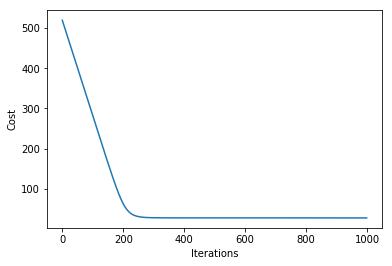

In [0]:
z = np.arange(0, MAX_ITER)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(z, cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

## Tuning Logistic Regression
Now that we have some insight into the way that this algorithm works, let us look at a few parameters that may be tuned in the Scikit-learn library. First, we could load up the full breast cancer dataset as a working example.

In [0]:
# load the dataset
breast_cancer = load_breast_cancer()

data_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)

data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

Next, we split the data into a training set and a test set and train a Logistic Regression model on the training data. Scikit-learn's defaults provide certain optimizations, so let us deliberately start with no tuning by turning off some of those optimizations.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_df, breast_cancer.target)

lr = LogisticRegression(solver='lbfgs', penalty='none')
lr.fit(X_train, y_train)

lr.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9090909090909091

By default, the maximum number of iterations is set to 100. Let's try increasing that and see if we get better results.

In [0]:
lr = LogisticRegression(solver='lbfgs', penalty='none', max_iter=1000)
lr.fit(X_train, y_train)

lr.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9370629370629371

The algorithm still failed to converge after 1000 iterations, lets increase it one more time.

In [0]:
lr = LogisticRegression(solver='lbfgs', penalty='none', max_iter=10000)
lr.fit(X_train, y_train)

lr.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9300699300699301

It seems that even after increasing the number of iterations we are still failing to converge and the accuracy is not improving either. Let us examine the effect of that penalty parameter.

## Regularization
Overfitting occurs when the model becomes too specific to the training data and does not generalize to previously unseen data. We can test for overfitting by comparing how well the model scores on the training data itself versus the test data. In the following code, we train and test a model on both the training data itself and the test data.

In [0]:
lr = LogisticRegression(solver='lbfgs', penalty='none', max_iter=10000)
lr.fit(X_train, y_train)

test_score = lr.score(X_test, y_test)
train_score = lr.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.9859154929577465
Score on test data:  0.9300699300699301


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Here we see a better score on the training data than the test data. This may indicate that some overfitting is happening. One way to combat overfitting is to use regularization. Regularization has the effect of reducing the variance between coefficients. This means the model does not fit the training data quite as well but should generalize to unseen data better.

There are several regularization options available. Two popular types are named **L1** and **L2** and both are available in Scikit-learn. By default, the **lbfgs** solver uses **L2** regularization, but we will be explicit for demonstration purposes and specify the **L2** with the *penalty* parameter. **L2** regularization modifies the cost function such that a larger penalty is imposed on larger coefficients making the algorithm biased towards smaller coeffiecients.

In [0]:
lr_regularized = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000)
lr_regularized.fit(X_train, y_train)

test_score = lr_regularized.score(X_test, y_test)
train_score = lr_regularized.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.971830985915493
Score on test data:  0.9300699300699301


First, notice that with regularization turned on the algorithm converged to a minimum. Also notice that the score on the training data reduced by a little, indicating that less overfitting is happening. To understand the effect of regularization let us plot the final coefficients generated using no regularization and using L2 regularization. As mentioned above, regularization reduces the variance, effectively smoothing out the decision boundary making the resulting model generalize to unseen data better.

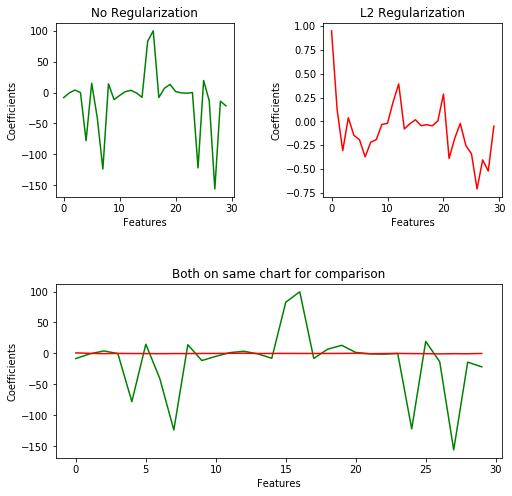

In [0]:
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.5)


x = np.arange(0, len(lr.coef_[0]),1)
y = lr.coef_[0]
ax1 = fig.add_subplot(grid[0, 0])
ax1.plot(x, y, '-g')
ax1.set(xlabel='Features', ylabel='Coefficients')
ax1.set_title('No Regularization')

y_reg = lr_regularized.coef_[0]
ax2 = fig.add_subplot(grid[0, 1])
ax2.plot(x, y_reg, '-r')
ax2.set(xlabel='Features', ylabel='Coefficients')
ax2.set_title('L2 Regularization')

ax3 = fig.add_subplot(grid[1, 0:])
ax3.plot(x, y, '-g')
ax3.plot(x, y_reg, '-r')

ax3.set(xlabel='Features', ylabel='Coefficients')
ax3.set_title('Both on same chart for comparison')
plt.show()

With no regularization we see that the coefficient values range from -80 to 40. With regularization, the values range from -1 to 1. In addition to just choosing the regularization algorithm, we can tune how it works by adjusting the parameter **C**. C is an inverse regularization strength parameter meaning that lower values of C cause stronger regularization. 

Choosing an appropriate value of C can be tricky. It may be necessary to try various values and pick the one that minimizes the difference between training accuracy and test accuracy. In the following code, we create many Logistic Regression models with different values of C and plot the training and test accuracy. 

***Note: the following code may take some time to execute as it is running the Logistic Regression algorithm several times. If it causes a problem you can try selecting a subset of the data and running this code with less data.***

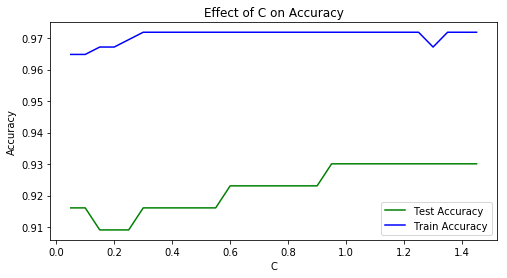

In [0]:
c_vals = np.arange(0.05, 1.5, 0.05)
test_accuracy = []
train_accuracy = []

for c in c_vals:
  lr = LogisticRegression(solver='lbfgs', penalty='l2', C=c, max_iter=10000)
  lr.fit(X_train, y_train)
  test_accuracy.append(lr.score(X_test, y_test))
  train_accuracy.append(lr.score(X_train, y_train))

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(c_vals, test_accuracy, '-g', label='Test Accuracy')
ax1.plot(c_vals, train_accuracy, '-b', label='Train Accuracy')
ax1.set(xlabel='C', ylabel='Accuracy')
ax1.set_title('Effect of C on Accuracy')
ax1.legend()
plt.show()

We can see that we get the best test accuracy somewhere between 0.5 and 0.95. The minimum distance between train and test accuracy in this range seem to occur around the 0.6 mark. For this example, 0.6 might be the best choice for C.

## Choosing a Solver
In the above example we used the [**lbfgs**](https://en.wikipedia.org/wiki/Limited-memory_BFGS) solver. We do not need to get into all the details of how this algorithm works but you can think of it as a more complex variation of the gradient descent algorithm. Scikit-learn will choose this as it's default solver from version 0.22 on. It is good for small datasets but, as we saw above, may fail to converge.

For larger datasets, the SAG or SAGA solvers are better choices. It may be useful at this point to simply try the various solvers and compare their results. From the scikit-learn documentation:

```
Algorithm to use in the optimization problem.

  For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
  For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;   
 ‘liblinear’ is limited to one-versus-rest schemes.
 ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
 ‘liblinear’ and ‘saga’ also handle L1 penalty
 ‘saga’ also supports ‘elasticnet’ penalty
 ‘liblinear’ does not handle no penalty

Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.
```

## Scaling
One final optimization is scaling the features so that they are approximately the same scale. Some solvers are affected by this. Scikit-learn has built-in several different scalers. Let us look at the effect of scaling on the model that we worked with above. First, let us look at a summary of the variance in each feature of the data.

In [0]:
data_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


We can see that each feature is on a different scale. For example, the mean radius ranges from 6.98 to 28.11 while mean area ranges from 654 to 2501. Let's use the standard scaler to scale these features.

In [0]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_df)
data_df_scaled = pd.DataFrame(scaled_data, columns=breast_cancer.feature_names)
data_df_scaled.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-3.162867e-15,-6.530609e-15,-7.078891e-16,-8.799835e-16,6.132177e-15,-1.120369e-15,-4.421380e-16,9.732500e-16,-1.971670e-15,-1.453631e-15,-9.076415e-16,-8.853492e-16,1.773674e-15,-8.291551e-16,-7.541809e-16,-3.921877e-16,7.917900e-16,-2.739461e-16,-3.108234e-16,-3.366766e-16,-2.333224e-15,1.763674e-15,-1.198026e-15,5.049661e-16,-5.213170e-15,-2.174788e-15,6.856456e-16,-1.412656e-16,-2.289567e-15,2.575171e-15
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,-1.059924e+00,-1.554264e+00,-1.044049e+00,-7.378291e-01,-1.776065e+00,-1.298098e+00,-1.057501e+00,-1.913447e+00,-1.532890e+00,-1.096968e+00,-1.726901e+00,-2.223994e+00,-1.693361e+00,-1.222423e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,-6.235706e-01,-6.948092e-01,-6.237679e-01,-4.947542e-01,-6.240183e-01,-6.929263e-01,-5.571612e-01,-6.744900e-01,-6.516807e-01,-5.851185e-01,-6.749213e-01,-7.486293e-01,-6.895783e-01,-6.421359e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,-2.922452e-01,-1.974976e-01,-2.866520e-01,-3.477828e-01,-2.203352e-01,-2.810204e-01,-1.990654e-01,-1.404958e-01,-2.194304e-01,-2.299405e-01,-2.690395e-01,-4.351564e-02,-2.859802e-01,-3.411812e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,2.660996e-01,4.665523e-01,2.430307e-01,1.067726e-01,3.683553e-01,3.896541e-01,3.367521e-01,4.726567e-01,3.556925e-01,2.886421e-01,5.220158e-01,6.583411e-01,5.402790e-01,3.575891e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,8.906909e+00,6.655279e+00,9.461986e+00,1.104184e+01,8.029999e+00,6.143482e+00,1.207268e+01,6.649601e+00,7.071917e+00,9.851593e+00,4.094189e+00,3.885905e+00,4.287337e+00,5.930172e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


Now each feature is in roughly the same scale. Let us use this scaled dataset to train the Logistic Regression model and compare it to the results we got from above.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_df_scaled, breast_cancer.target)
lr = LogisticRegression(solver='lbfgs', max_iter=10000, penalty='l2', C=0.6)
lr.fit(X_train, y_train)

test_score = lr.score(X_test, y_test)
train_score = lr.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.9929577464788732
Score on test data:  0.958041958041958


A very significant increase in test accuracy. A careful comparison of the various solvers, regularization values, and scaling will usually reveal the best combination for the best results.